## PyTorch/TPU MNIST Demo

This colab example corresponds to the implementation under [test_train_mp_mnist.py](https://github.com/pytorch/xla/blob/master/test/test_train_mp_mnist.py).

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 26 kB/s 
     |████████████████████████████████| 776.3 MB 18 kB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have tor

### If you're using GPU with this colab notebook, run the below commented code to install GPU compatible PyTorch wheel and dependencies

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl --force-reinstall 

### Only run the below commented cell if you would like a nightly release

In [ ]:
# VERSION = "1.12"  #@param ["1.12", "nightly", "20220315"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os 
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

### Define Parameters and Helpers, and start Training


In [ ]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [ ]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 256
FLAGS['num_workers'] = 2
FLAGS['learning_rate'] = 0.001
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 1
FLAGS['log_steps'] = 0
FLAGS['metrics_debug'] = False

In [ ]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms
import gc

SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)
  
  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if FLAGS['log_steps'] > 0 and x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = correct / total_samples
    print('[xla:{}] Accuracy={:.4f}'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))
  
  gc.collect()
  print("Train accuracy")
  para_loader = pl.ParallelLoader(train_loader, [device])
  accuracy, _, _, _  = test_loop_fn(para_loader.per_device_loader(device))

  test_para_loader = pl.ParallelLoader(test_loader, [device])
  print("Test accuracy")
  accuracy, data, pred, target  = test_loop_fn(test_para_loader.per_device_loader(device))
  if FLAGS['metrics_debug']:
    xm.master_print(met.metrics_report(), flush=True)
  gc.collect()

  return accuracy, data, pred, target

In [ ]:
from time import perf_counter

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
#   if rank == 0:
#     # Retrieve tensors that are on TPU core 0 and plot.
#     plot_results(data.cpu(), pred.cpu(), target.cpu())

start = perf_counter()
FLAGS['num_epochs'] = 30
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

print(f'Performance {perf_counter()-start}')

Finished training epoch 1
Finished training epoch 2
Finished training epoch 3
Finished training epoch 4
Finished training epoch 5
Finished training epoch 6
Finished training epoch 7
Finished training epoch 8
Finished training epoch 9
Finished training epoch 10
Finished training epoch 11
Finished training epoch 12
Finished training epoch 13
Finished training epoch 14
Finished training epoch 15
Finished training epoch 16
Finished training epoch 17
Finished training epoch 18
Finished training epoch 19
Finished training epoch 20
Finished training epoch 21
Finished training epoch 22
Finished training epoch 23
Finished training epoch 24
Finished training epoch 25
Finished training epoch 26
Finished training epoch 27
Finished training epoch 28
Finished training epoch 29
Finished training epoch 30
Train accuracy
[xla:0] Accuracy=0.9865
Test accuracy
[xla:0] Accuracy=0.9860
Performance 392.36089868100044


## Visualize Predictions

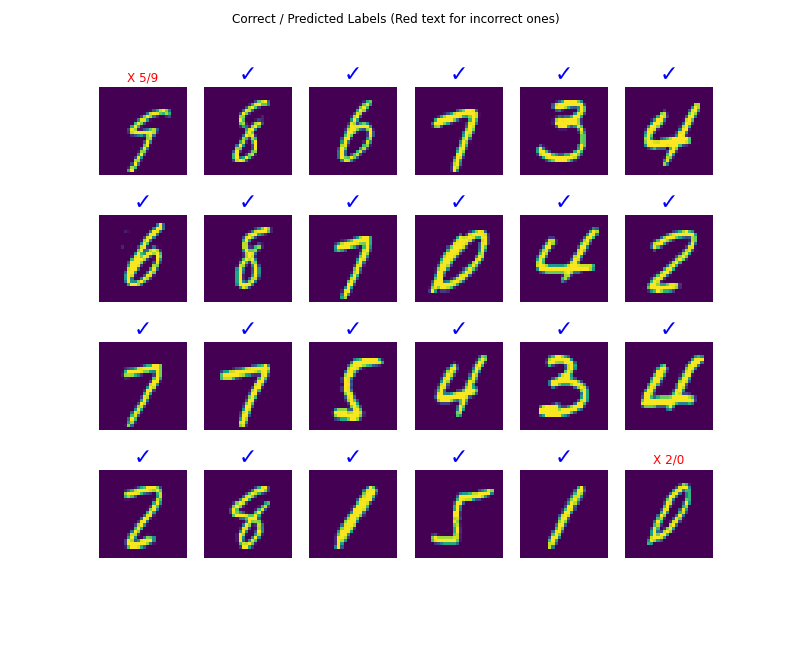

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)